In [17]:
import numpy as np
import yaml
np.random.seed(42)
import os
from resolve.polynomial_chaos_expansion import PCEMultiFidelityModelVisualizer
import matplotlib.pyplot as plt
from scipy.stats import poisson
import matplotlib.pyplot as plt
import arviz as az
import xarray as xr
import emcee

In [18]:
path_to_settings = ".."
with open(f"{path_to_settings}/settings.yaml", "r") as f:
    config_file = yaml.safe_load(f)

version       = config_file["path_settings"]["version"]
path_out_cnp  = config_file["path_settings"]["path_out_cnp"]
path_out_cnp  += f"/{version}"
path_out_pce = config_file["path_settings"]["path_out_pce"]
path_out_pce  += f"/{version}"
file_in=f'{path_out_cnp}/cnp_{version}_output.csv'



In [19]:

if not os.path.exists(path_out_pce):
   os.makedirs(path_out_pce)

# Set parameter name/x_labels -> needs to be consistent with data input file
x_labels        = config_file["simulation_settings"]["theta_headers"]
x_labels_plot   = config_file["simulation_settings"]["theta_headers_plot"]
y_label_cnp     = 'y_cnp'
y_err_label_cnp = 'y_cnp_err'
y_label_sim     = 'y_raw'

# Set parameter boundaries
xmin = config_file["simulation_settings"]["theta_min"]
xmax = config_file["simulation_settings"]["theta_max"]
x_fixed = config_file["simulation_settings"]["theta_fixed"]
parameters={}
for i,x in enumerate(x_labels):
   parameters[x]=[xmin[i],xmax[i]]



In [20]:
fidelities = list(config_file["pce_settings"]["priors"].keys())

polynomial_order = config_file["pce_settings"]["polynomial_order"]
degree = [polynomial_order,1]


In [21]:
trace = az.from_netcdf(f"{path_out_pce}/trace.nc")
pce_visualizer= PCEMultiFidelityModelVisualizer(fidelities=fidelities,parameters=parameters,trace=trace,degree=degree)

In [22]:

VT = config_file["simulation_settings"]["y_scaling"]
k_obs = config_file["simulation_settings"]["observed_rate"]
#pce_visualizer.set_y_scaling(y_scaling)

$P(n_{merge} | data) \sim P(data | n_{merge}) \cdot P(n_{merge}) = L(data | R(\theta)) \cdot P(R(\theta)) \cdot P(\theta) = Poiss(data | R(\theta_1,\theta_2,\theta_3,\theta_4)) \cdot P(R(\theta_1,\theta_2,\theta_3,\theta_4)) \cdot P(\theta_1)\cdot P(\theta_2)\cdot P(\theta_3)\cdot P(\theta_4)$

$P(n_{merge} | data) \sim P(data | n_{merge}) \cdot P(n_{merge}) = L(data | R(\theta)) \cdot P(R(\theta)) \cdot P(\theta) = Poiss(data | R(\theta_1,\theta_2,\theta_3,\theta_4)) \cdot P(R(\theta_1,\theta_2,\theta_3,\theta_4)) \cdot P(\theta_1)\cdot P(\theta_2)\cdot P(\theta_3)\cdot P(\theta_4)$

In [23]:


# log-prior for theta
def log_prior(theta):
    metallicity, alpha_CE, sigma_BH, sigma_NS = theta
    if 0.005 <= metallicity <= 0.03 and 0 <= alpha_CE <= 100 and 0 <= sigma_BH <= 1000 and 0 <= sigma_NS <= 1000:
        return 0.0  # flat prior
    return -np.inf

# log-likelihood with marginalized surrogate posterior
def log_likelihood(theta):
    # Get posterior samples from surrogate
    theta_tmp = np.array(theta)
    theta_tmp = theta_tmp.reshape(1,-1)
    R_samples = pce_visualizer.predict(theta_tmp)  # shape: (8000,1)
    if np.isnan(R_samples).any():
        print("There are NaNs in R_samples")

    # Compute Poisson likelihood for each sample
    mu_samples = R_samples * VT  # expected counts for each R

    mu = R_samples.flatten() * VT
    valid = mu > 0
    likelihoods = poisson.pmf(k_obs, mu=R_samples * VT)
    valid = np.isfinite(likelihoods) & (likelihoods > 0)
    if np.any(valid):
        log_likelihood = np.log(np.mean(likelihoods[valid]))
    else:
        log_likelihood = -np.inf
    return log_likelihood

# full log-prob for emcee
def log_prob(theta):
    lp = log_prior(theta)

    if not np.isfinite(lp):
        return -np.inf
    ll = log_likelihood(theta)
    return lp + ll

In [24]:
# Initialize walkers
ndim = 4
nwalkers = 32
p0 = np.random.uniform(
    low=xmin,
    high=xmax,
    size=(nwalkers, ndim)
)

In [25]:
# Sampler
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob)
sampler.run_mcmc(p0, 1000, progress=True)

# Extract posterior samples
samples = sampler.get_chain(discard=100, flat=True)

  0%|          | 0/1000 [00:00<?, ?it/s]/global/cfs/projectdirs/katrin/users/aschuetz/software/conda_envs/resum/lib/python3.10/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 1000/1000 [02:47<00:00,  5.97it/s]


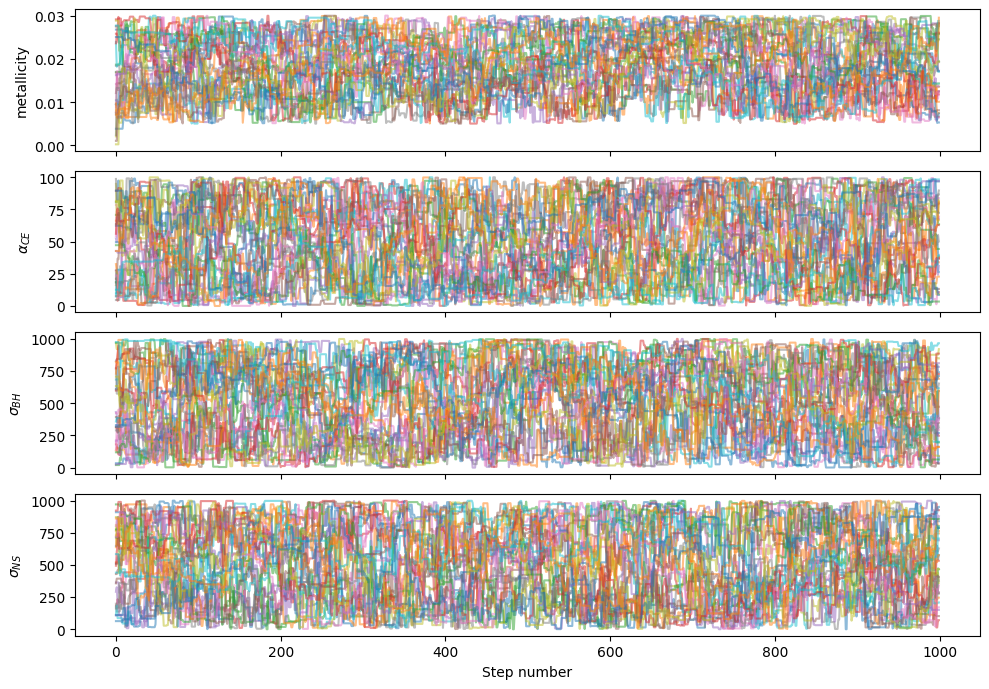

In [26]:


fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
labels = x_labels_plot

for i in range(ndim):
    axes[i].plot(sampler.get_chain()[:, :, i], alpha=0.5)
    axes[i].set_ylabel(labels[i])
axes[-1].set_xlabel("Step number")
plt.tight_layout()
plt.show()

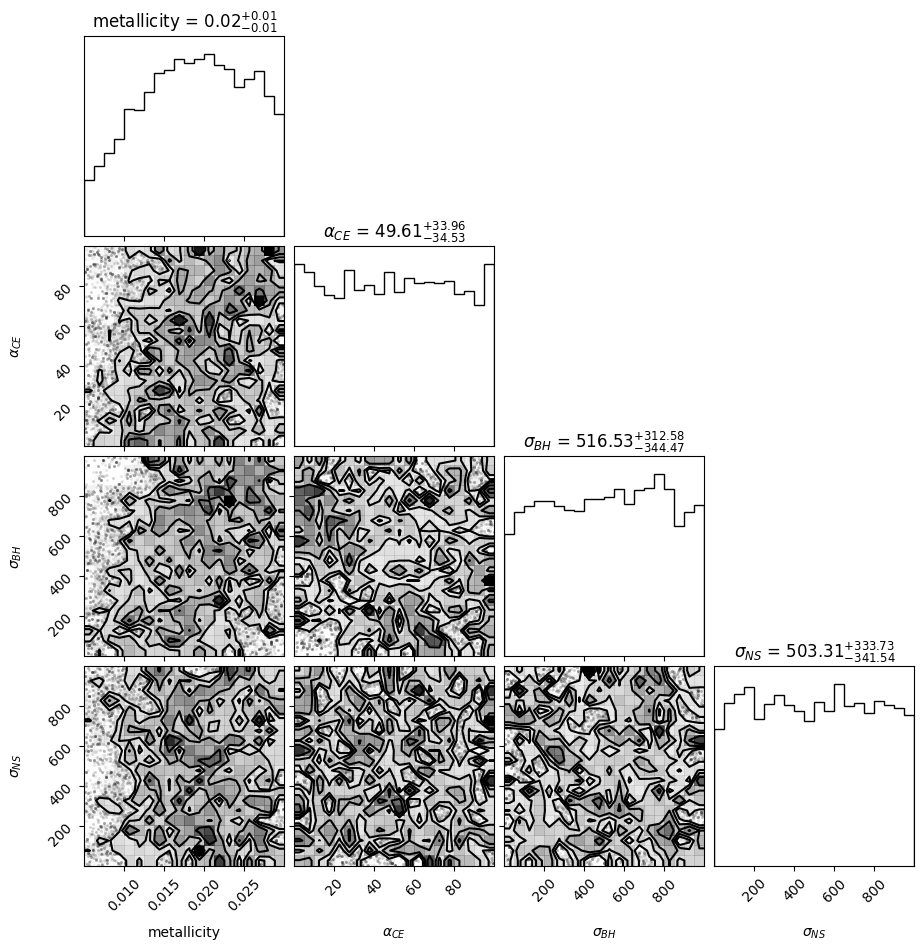

In [27]:
import corner

fig = corner.corner(samples, labels=labels, truths=None, show_titles=True)
plt.show()

In [28]:
import numpy as np

for i, label in enumerate(labels):
    mcmc = np.percentile(samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    print(f"{label:12s} = {mcmc[1]:.4f} +{q[1]:.4f} -{q[0]:.4f}")

metallicity  = 0.0189 +0.0072 -0.0075
$\alpha_{CE}$ = 49.6063 +33.9642 -34.5260
$\sigma_{BH}$ = 516.5284 +312.5794 -344.4717
$\sigma_{NS}$ = 503.3099 +333.7305 -341.5401


In [29]:
n_chains = 32
n_draws = samples.shape[0] // n_chains
samples_reshaped = samples.reshape((n_chains, n_draws, 4))  # (chains, draws, parameters)

In [30]:
# Create an xarray Dataset with named parameters
posterior_parameters = {}
for i,l in enumerate(x_labels_plot):
    posterior_parameters[l] = (["chain", "draw"], samples_reshaped[:, :, i])
posterior = xr.Dataset( posterior_parameters
)

# Now convert to InferenceData
idata = az.convert_to_inference_data(posterior)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
metallicity,0.019,0.006,0.008,0.030,0.000,0.000,28357.0,28264.0,1.02
$\alpha_{CE}$,49.626,29.049,3.150,97.331,0.174,0.078,27862.0,27179.0,1.01
$\sigma_{BH}$,509.108,282.670,43.418,968.200,1.714,0.744,27723.0,27950.0,1.01
$\sigma_{NS}$,499.762,286.664,54.546,985.336,1.655,0.742,30364.0,29090.0,1.01


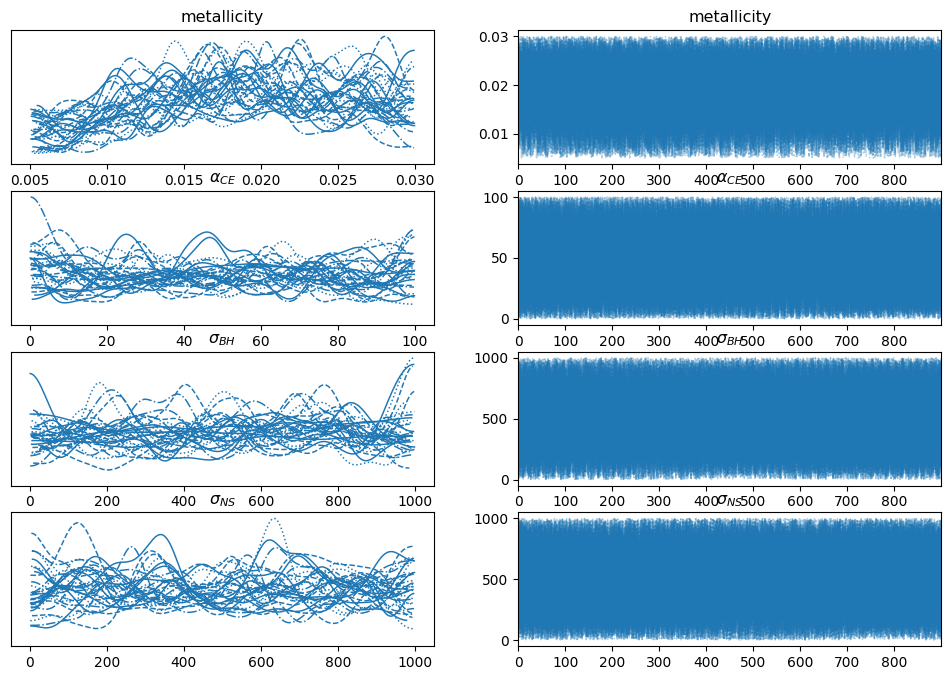

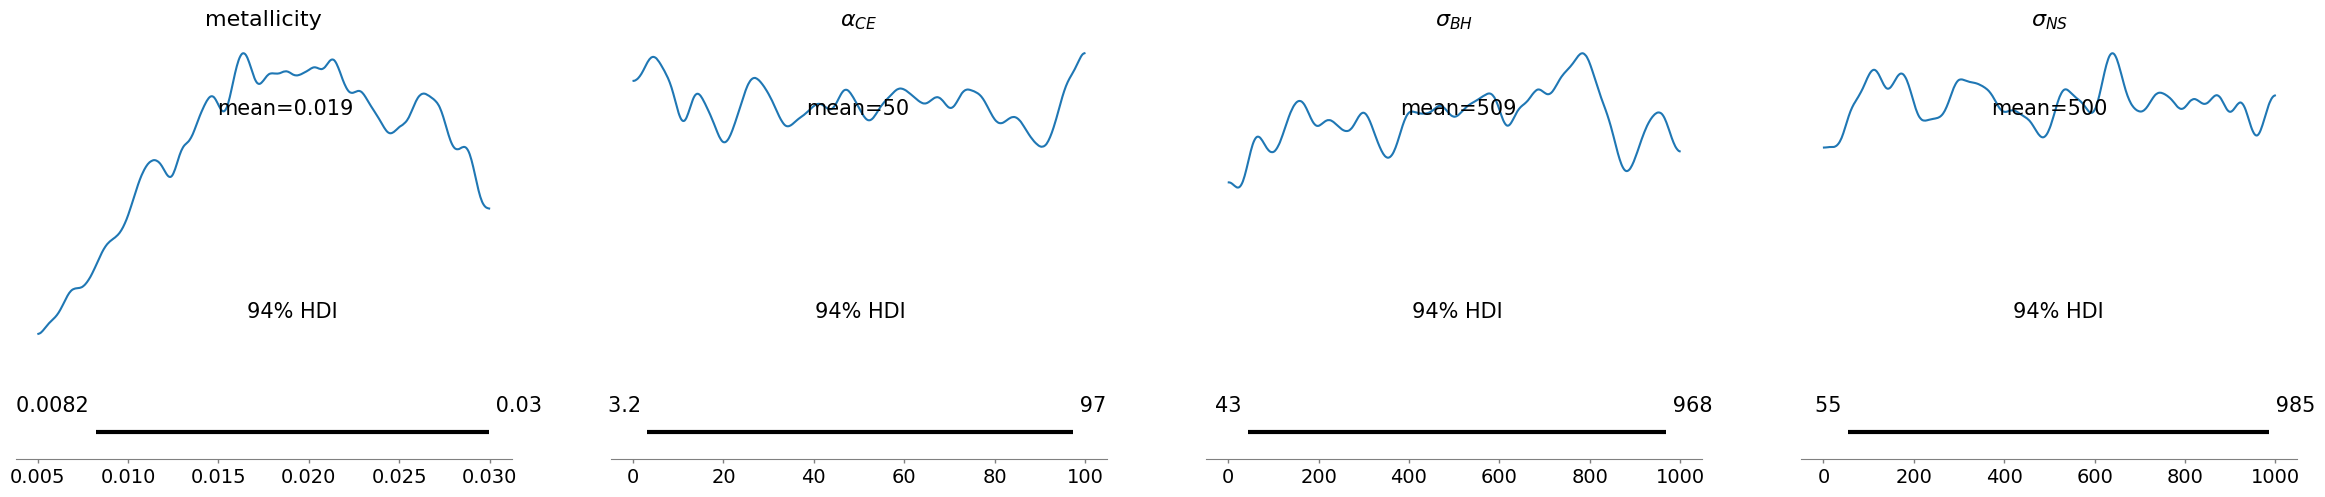

In [31]:
az.plot_trace(idata)
az.plot_posterior(idata)
az.summary(idata)

/global/cfs/projectdirs/katrin/users/aschuetz/software/conda_envs/resum/lib/python3.10/site-packages/arviz/plots/pairplot.py:224: UserWarning: Divergences data not found, plotting without divergences. Make sure the sample method provides divergences data and that it is present in the `diverging` field of `sample_stats` or `sample_stats_prior` or set divergences=False
  warnings.warn(


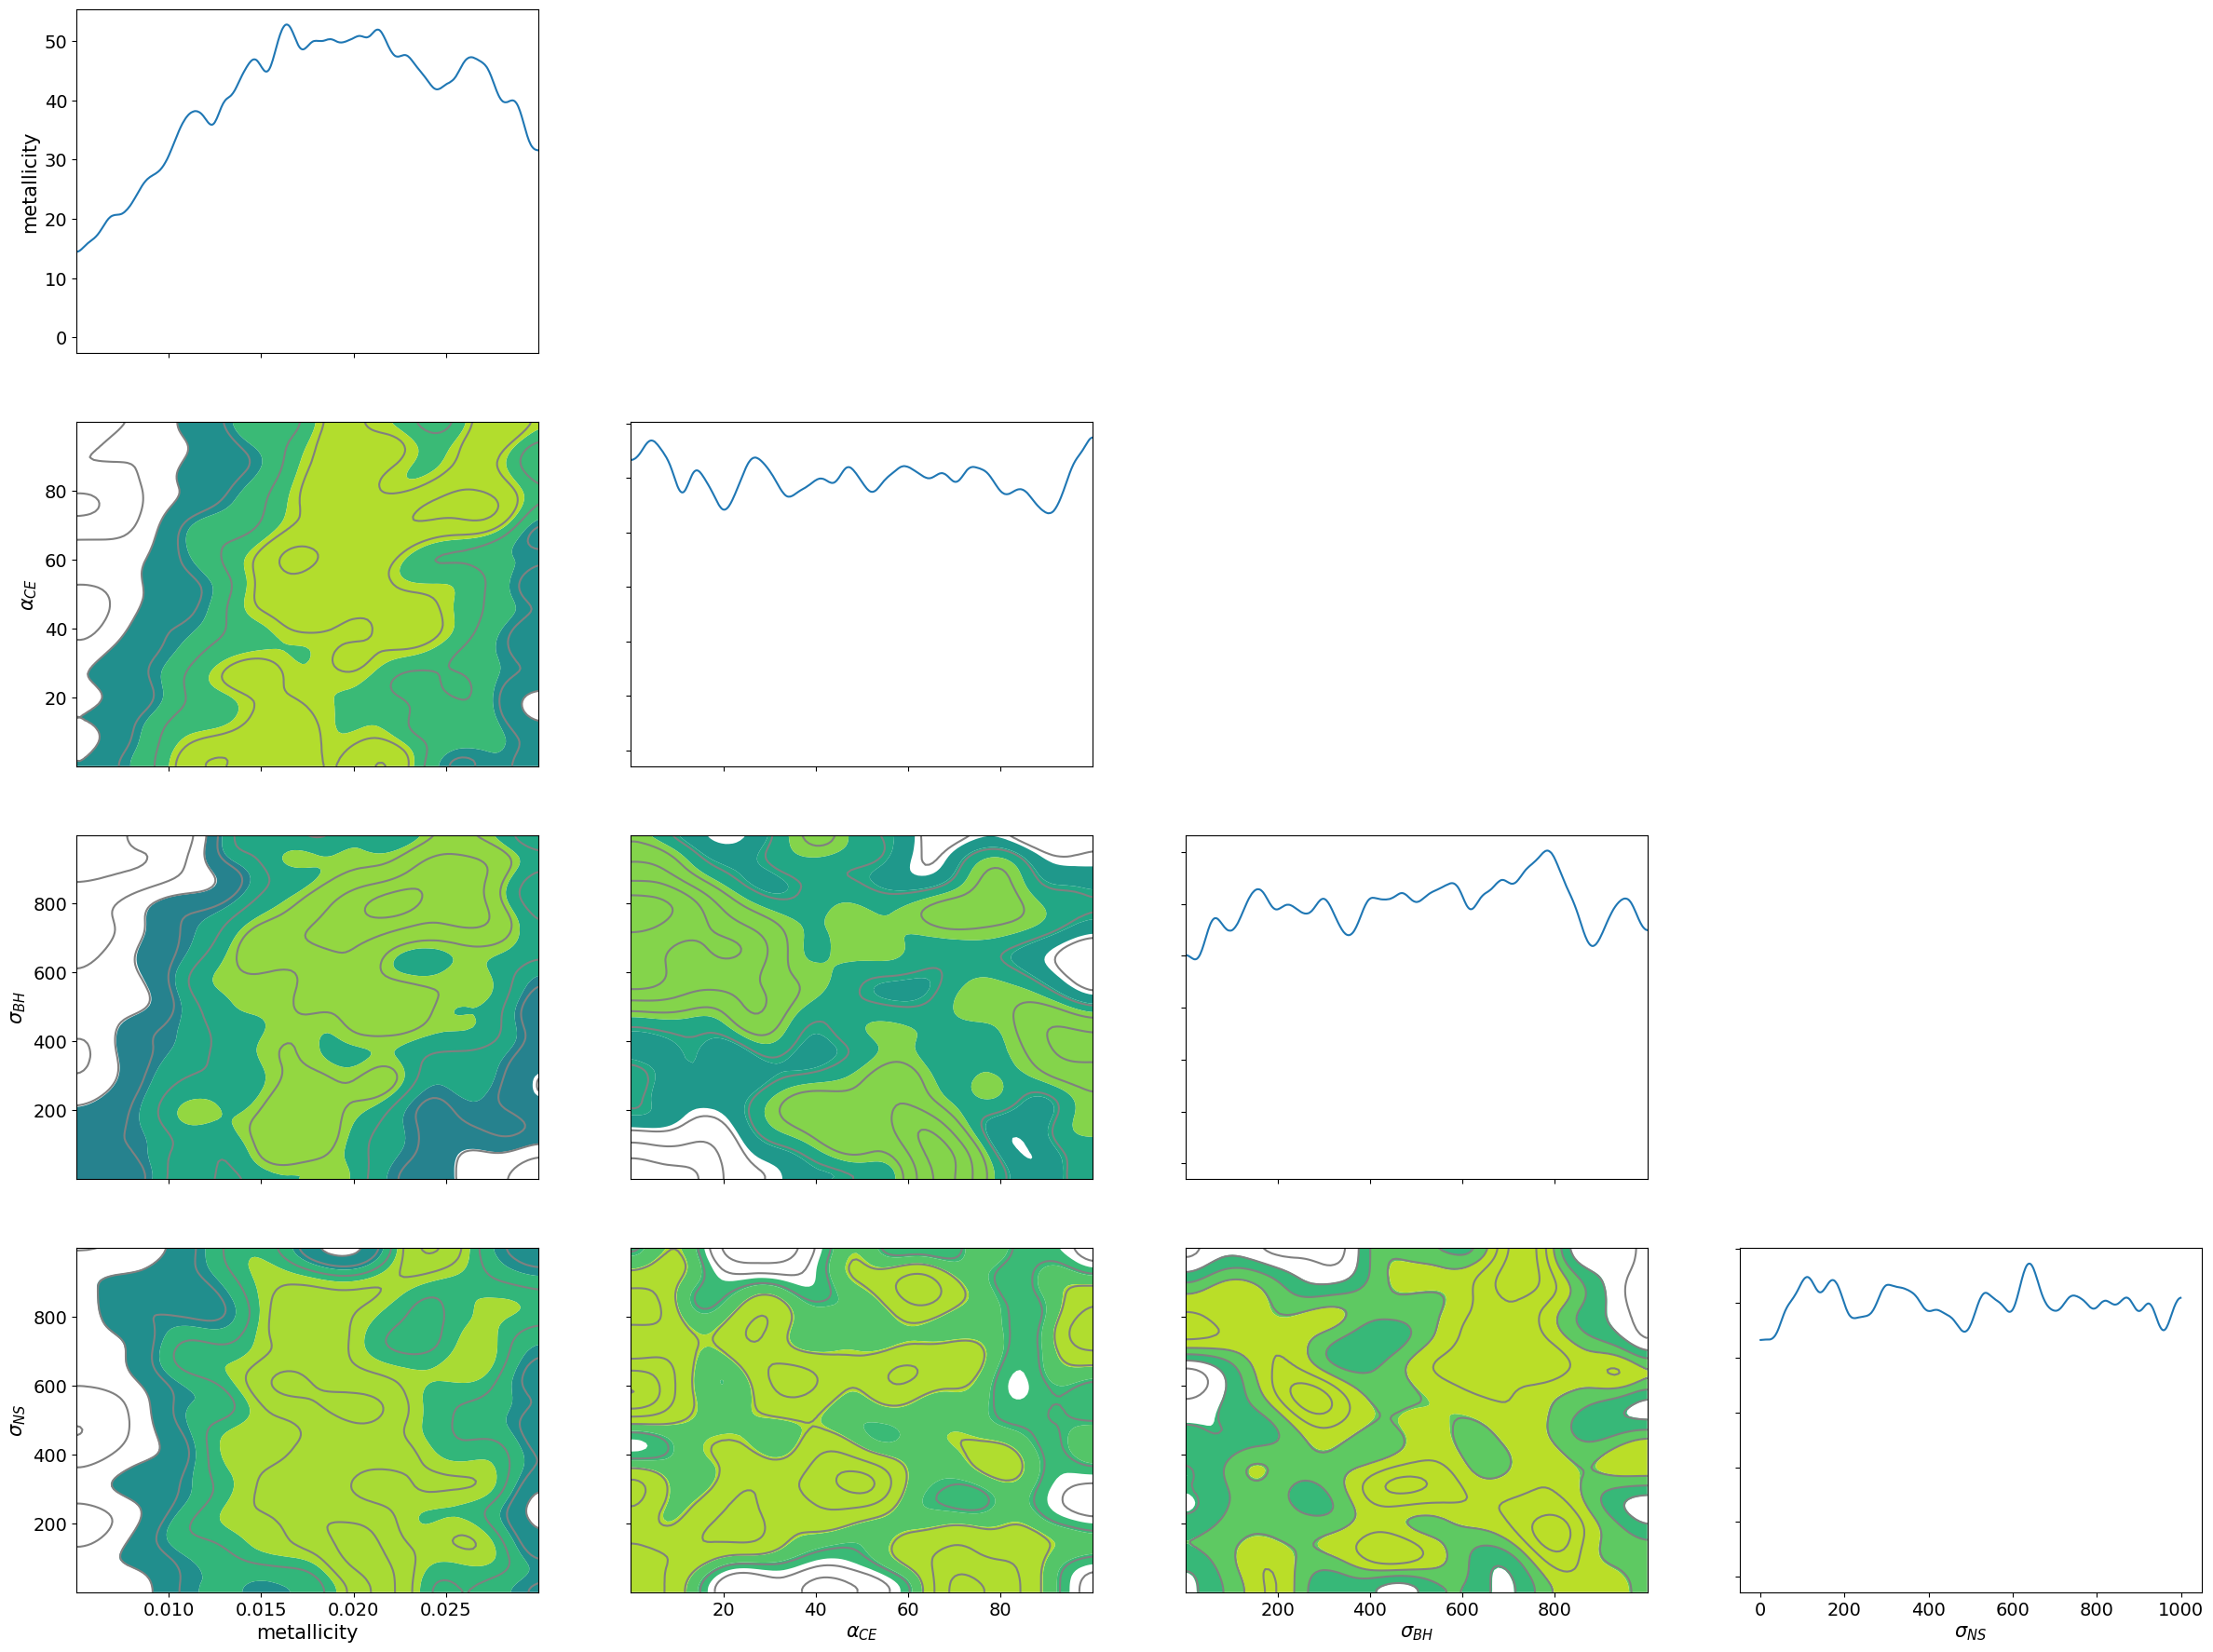

In [32]:
ax = az.plot_pair(idata, kind='kde', divergences=True, marginals=True)